## TwoStep
This method will use a **2-step method** for **positive-unlabeled** classifier learning [(Kaboutari, et al. 2014)](https://www.semanticscholar.org/paper/An-Evaluation-of-Two-Step-Techniques-for-Learning-Kaboutari-Bagherzadeh/bd10ba5f30744e4755cbe7757e8c657ce5d6ec45)
1. Choose datapoints (droplets) that are confidently positive for the given label (in our case, empty droplets and dead cells)
2. Use some method of determining datapoints (droplets) that are confidently negative for the given label (we can use UMI ranking and MT enrichment of clusters)

In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80)

### Load data and preprocess

Read in normal human colon sample

In [2]:
%time s1 = sc.read_h5ad('../data/2771-AS-2-CTTGTA_S2.h5ad')

CPU times: user 2.21 s, sys: 359 ms, total: 2.57 s
Wall time: 2.61 s


In [3]:
# see how many "good cells" Ken labeled
s1.obs['ken_filter'].value_counts()

0    3721
1    1536
Name: ken_filter, dtype: int64

In [4]:
%%time
# preprocess data with fcc recipe
sc.pp.filter_genes(s1, min_cells=1)
recipe_fcc(s1, X_final='arcsinh_norm', mito_names='^mt-')
s1.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1.obs['n_genes_by_counts'])

CPU times: user 11.3 s, sys: 2.03 s, total: 13.3 s
Wall time: 13.3 s


In [5]:
s1 # see what's in our object

AnnData object with n_obs × n_vars = 5257 × 28098 
    obs: 'ken_filter', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'arcsinh_total_counts', 'gf_icf_total', 'log1p_norm_factor', 'arcsinh_n_genes_by_counts'
    var: 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'raw_counts', 'arcsinh_norm', 'gf_icf', 'log1p_norm'

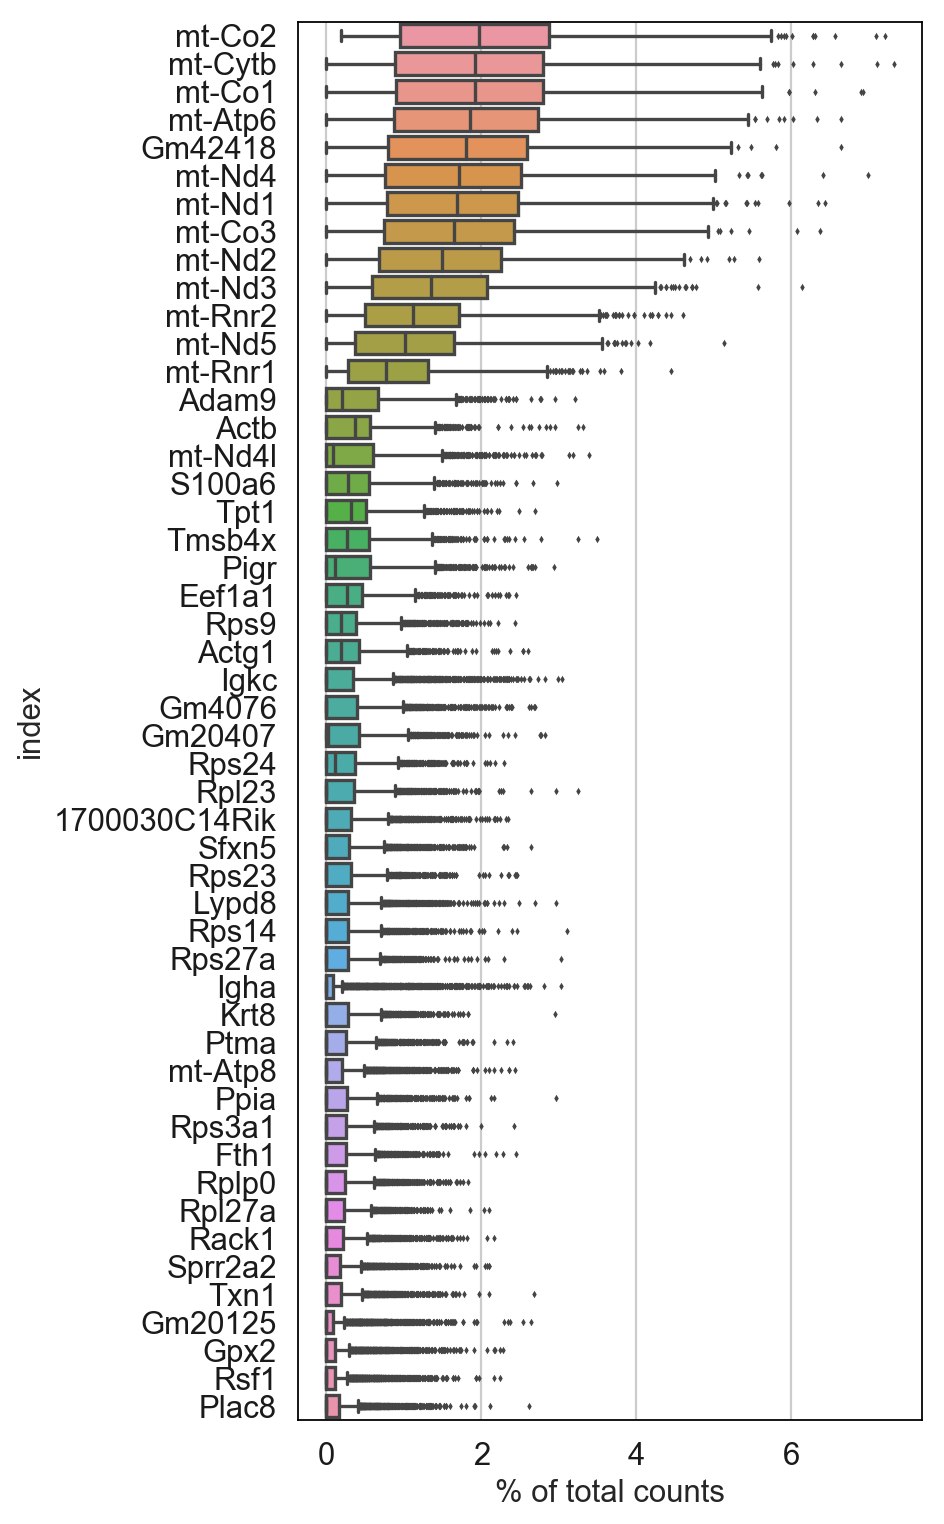

In [6]:
# pct counts in top 50 genes might be useful, as top genes are typically ambient (in empty drops at high frequency)
sc.pl.highest_expr_genes(s1, n_top=50)

### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [7]:
from skimage.filters import threshold_li, threshold_otsu, threshold_mean

In [8]:
# use a few methods on the log-transformed total counts for each barcode:
thresh_gficf = threshold_otsu(np.array(s1.obs['gf_icf_total']))
thresh_counts = threshold_otsu(np.array(s1.obs['arcsinh_total_counts']))
thresh_mito = threshold_otsu(np.array(s1.obs['pct_counts_mito']))
thresh_genes = threshold_otsu(np.array(s1.obs['arcsinh_n_genes_by_counts']))
thresh_50 = threshold_otsu(np.array(s1.obs['pct_counts_in_top_50_genes']))

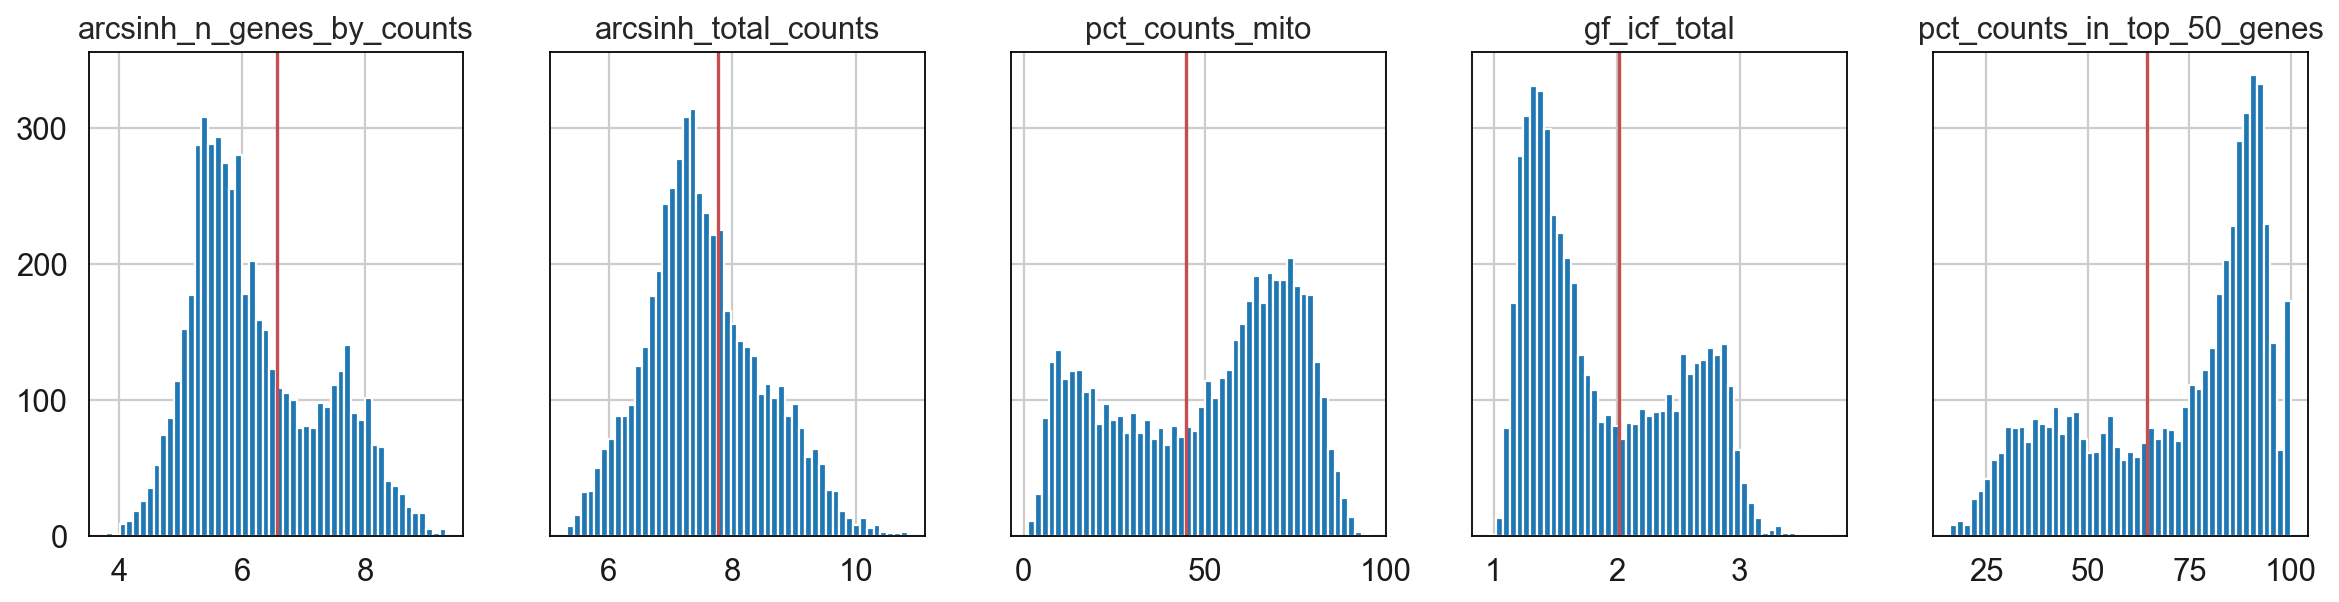

In [9]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(15,4), sharey=True)
axes[0].set_title('arcsinh_n_genes_by_counts')
axes[0].hist(s1.obs['arcsinh_n_genes_by_counts'], bins=50)
axes[0].axvline(thresh_genes, color='r')
axes[1].set_title('arcsinh_total_counts')
axes[1].hist(s1.obs['arcsinh_total_counts'], bins=50)
axes[1].axvline(thresh_counts, color='r')
axes[2].set_title('pct_counts_mito')
axes[2].hist(s1.obs['pct_counts_mito'], bins=50)
axes[2].axvline(thresh_mito, color='r')
axes[3].set_title('gf_icf_total')
axes[3].hist(s1.obs['gf_icf_total'], bins=50)
axes[3].axvline(thresh_gficf, color='r')
axes[4].set_title('pct_counts_in_top_50_genes')
axes[4].hist(s1.obs['pct_counts_in_top_50_genes'], bins=50)
axes[4].axvline(thresh_50, color='r')
plt.tight_layout()

### a couple different ways of visualizing these thresholds vs Ken's filter...

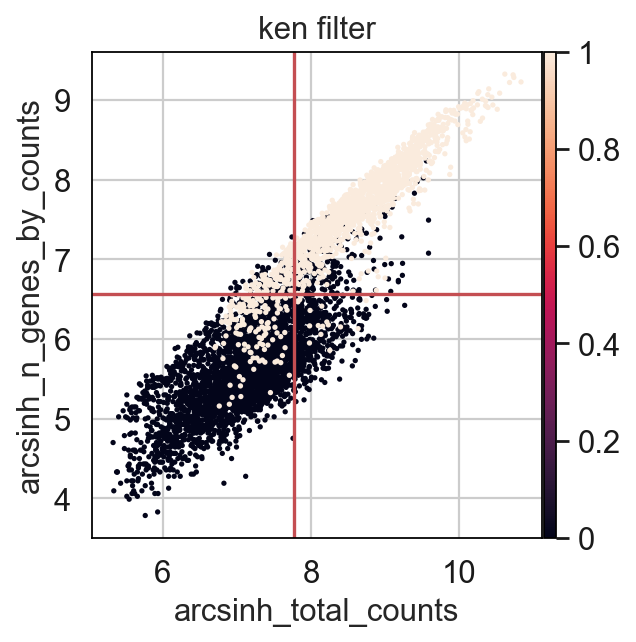

In [10]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='arcsinh_total_counts', color='ken_filter', show=False)
ax.axvline(thresh_counts, color='r')
ax.axhline(thresh_genes, color='r')
plt.show()

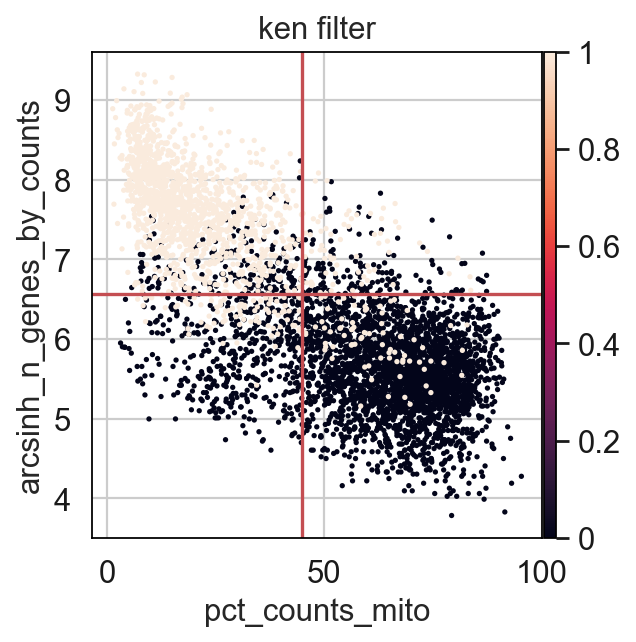

In [12]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='pct_counts_mito', color='ken_filter', show=False)
ax.axvline(thresh_mito, color='r')
ax.axhline(thresh_genes, color='r')
plt.show()

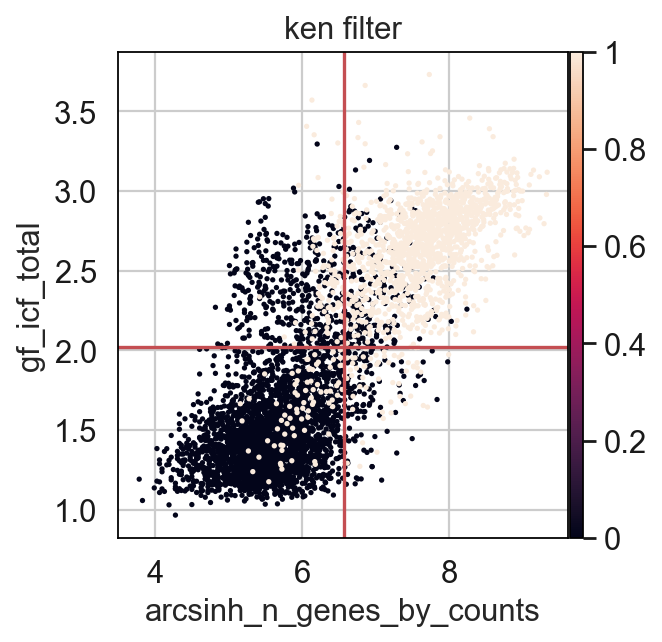

In [13]:
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='ken_filter', show=False)
ax.axvline(thresh_genes, color='r')
ax.axhline(thresh_gficf, color='r')
plt.show()

---
### Use combination of the above 5 filters to "hard threshold" our dataset and compare to Ken's labels

In [16]:
s1.obs['thresh_filter'] = 0
s1.obs.loc[(s1.obs['arcsinh_n_genes_by_counts']>=thresh_genes) & (s1.obs['gf_icf_total']>=thresh_gficf) & (s1.obs['arcsinh_total_counts']>=thresh_counts) & (s1.obs['pct_counts_mito']<=thresh_mito) & (s1.obs['pct_counts_in_top_50_genes']<=thresh_50), 'thresh_filter'] = 1

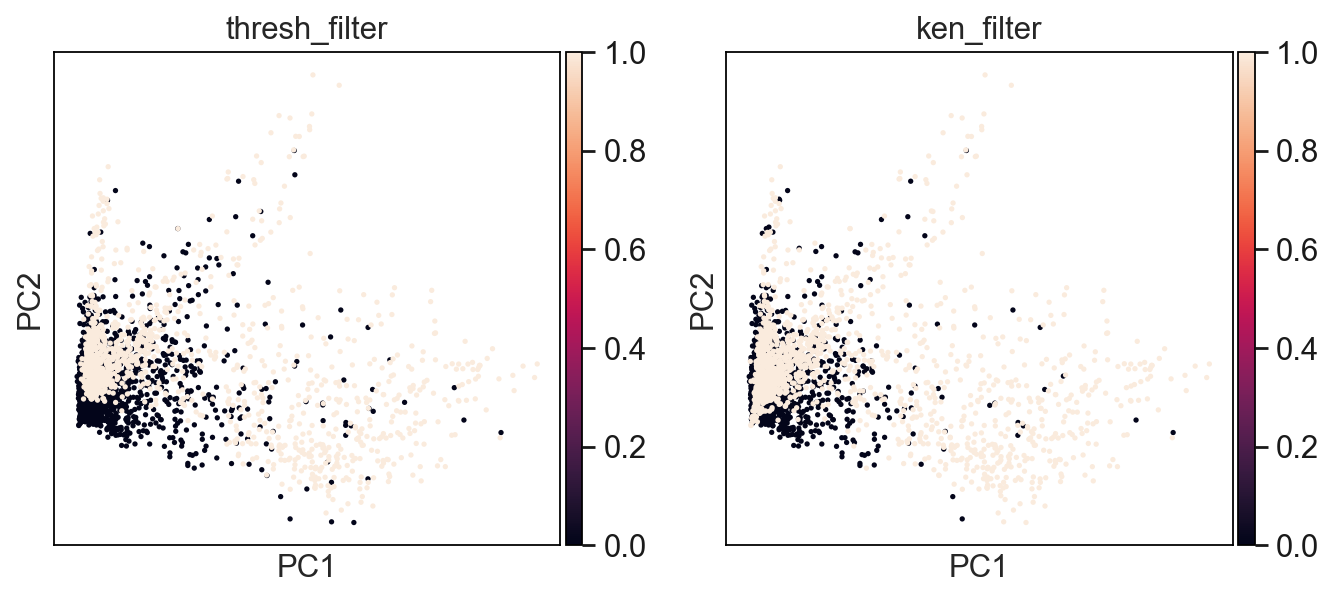

CPU times: user 2.94 s, sys: 539 ms, total: 3.48 s
Wall time: 841 ms


In [17]:
%%time
# perform 10-component PCA (for training our classifiers later) and look at the two filter labels side-by-side
sc.tl.pca(s1, n_comps=10)
sc.pl.pca(s1, color=['thresh_filter','ken_filter'])

#### Look at set differences with `ken_filter`:

In [18]:
len(set(s1.obs_names[s1.obs['thresh_filter']==1]).difference(set(s1.obs_names[s1.obs['ken_filter']==1])))

82

In [19]:
len(set(s1.obs_names[s1.obs['ken_filter']==1]).difference(set(s1.obs_names[s1.obs['thresh_filter']==1])))

356

In [20]:
len(set(s1.obs_names[s1.obs['thresh_filter']==1]) ^ set(s1.obs_names[s1.obs['ken_filter']==1]))

438

---
#### ~400 cell difference isn't bad with hard thresholding. Let's train a two-step PU classifier to reconfigure these labels.
#### First, pick reliable positives, or "bad" cells based on the above thresholds.
#### Below defines probabilities for random sampling these training cells

In [21]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['counts_prob'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['arcsinh_total_counts']<=thresh_counts, 'counts_prob'] = np.reciprocal(s1.obs.loc[s1.obs['arcsinh_total_counts']<=thresh_counts, 'arcsinh_total_counts']+1)
s1.obs['counts_prob'] /= s1.obs['counts_prob'].sum()

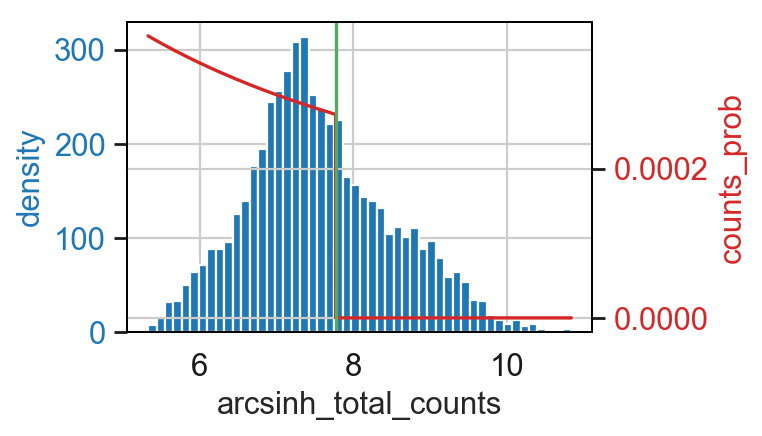

In [22]:
new_order = np.argsort(s1.obs['total_counts'])[::-1]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('arcsinh_total_counts')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['arcsinh_total_counts'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('counts_prob', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['arcsinh_total_counts'], s1.obs['counts_prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_counts, color='g') # li threshold

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [23]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['genes_prob'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['arcsinh_n_genes_by_counts']<=thresh_genes, 'genes_prob'] = np.reciprocal(s1.obs.loc[s1.obs['arcsinh_n_genes_by_counts']<=thresh_genes, 'arcsinh_n_genes_by_counts']+1)
s1.obs['genes_prob'] /= s1.obs['genes_prob'].sum()

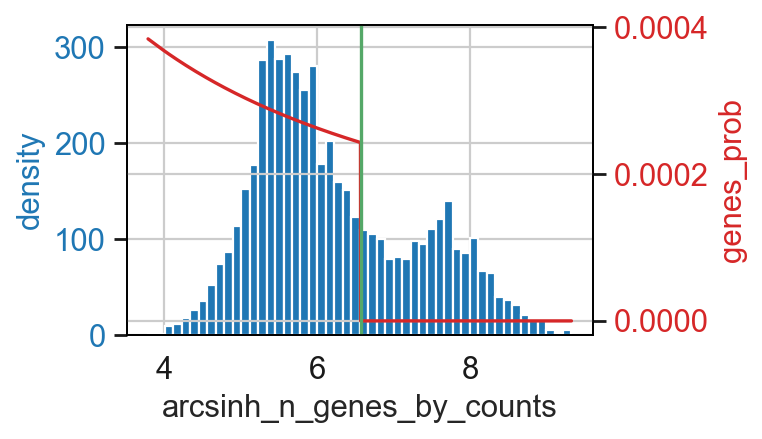

In [24]:
new_order = np.argsort(s1.obs['arcsinh_n_genes_by_counts'])[::-1]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('arcsinh_n_genes_by_counts')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['arcsinh_n_genes_by_counts'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('genes_prob', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['arcsinh_n_genes_by_counts'], s1.obs['genes_prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_genes, color='g') # li threshold

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [25]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['mito_prob'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['pct_counts_mito']>=thresh_mito, 'mito_prob'] = s1.obs.loc[s1.obs['pct_counts_mito']>=thresh_mito, 'pct_counts_mito']
s1.obs['mito_prob'] /= s1.obs['mito_prob'].sum()

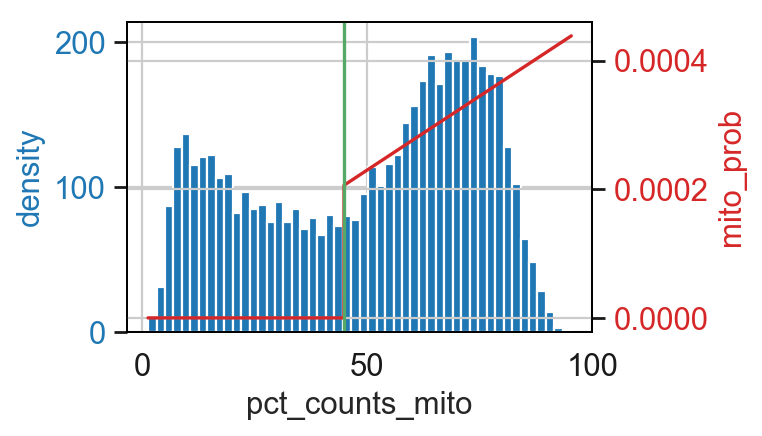

In [26]:
new_order = np.argsort(s1.obs['pct_counts_mito'])[:]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('pct_counts_mito')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['pct_counts_mito'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('mito_prob', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['pct_counts_mito'], s1.obs['mito_prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_mito, color='g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [27]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['50_prob'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['pct_counts_in_top_50_genes']>=thresh_50, '50_prob'] = s1.obs.loc[s1.obs['pct_counts_in_top_50_genes']>=thresh_50, 'pct_counts_in_top_50_genes']
s1.obs['50_prob'] /= s1.obs['50_prob'].sum()

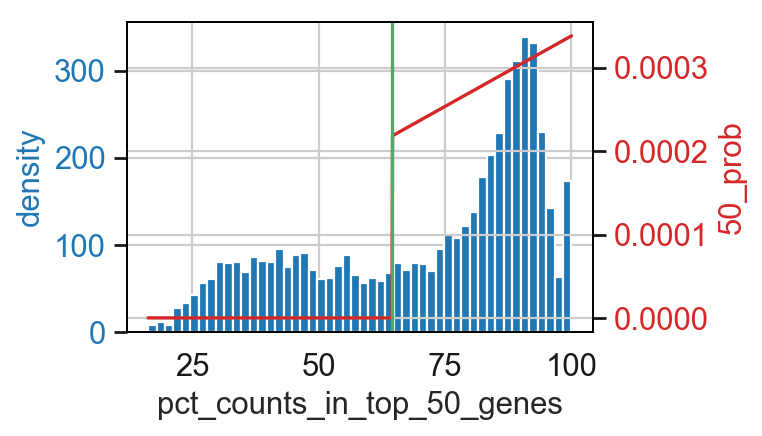

In [28]:
new_order = np.argsort(s1.obs['pct_counts_in_top_50_genes'])[:]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('pct_counts_in_top_50_genes')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['pct_counts_in_top_50_genes'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('50_prob', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['pct_counts_in_top_50_genes'], s1.obs['50_prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_50, color='g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [29]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['gficf_prob'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['gf_icf_total']<=thresh_gficf, 'gficf_prob'] = np.reciprocal(s1.obs.loc[s1.obs['gf_icf_total']<=thresh_gficf, 'gf_icf_total']+1)
s1.obs['gficf_prob'] /= s1.obs['gficf_prob'].sum()

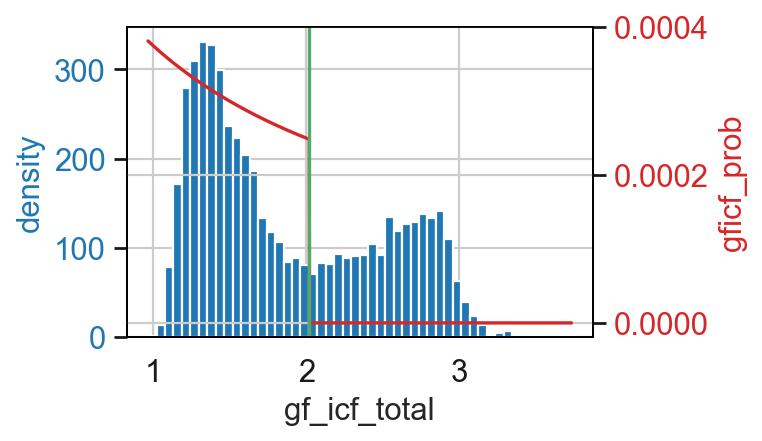

In [30]:
new_order = np.argsort(s1.obs['gf_icf_total'])[::-1]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('gf_icf_total')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['gf_icf_total'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('gficf_prob', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['gf_icf_total'], s1.obs['gficf_prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_gficf, color='g') # li threshold

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### combine probabilities for training set (bad/empty cells):

In [31]:
# combine and normalize probabilities
s1.obs['train_prob'] =  s1.obs['genes_prob'] + s1.obs['gficf_prob'] + s1.obs['counts_prob'] + s1.obs['50_prob'] + s1.obs['mito_prob']
s1.obs['train_prob'] /= s1.obs['train_prob'].sum()

#### A couple ways of visualizing these probabilities

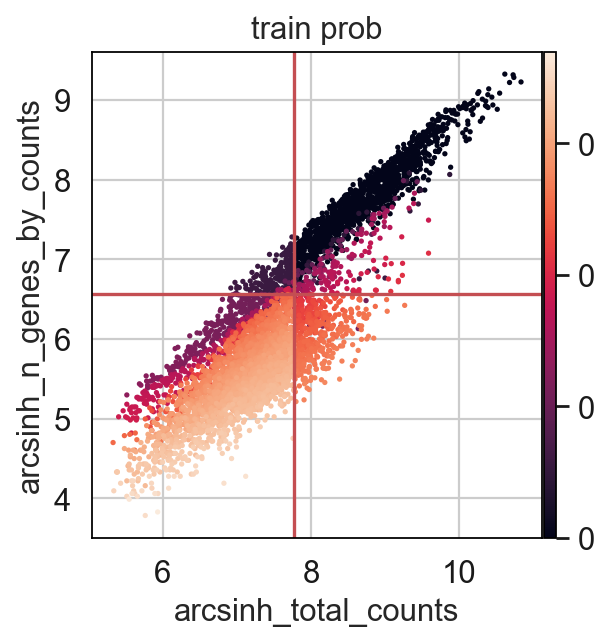

In [32]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='arcsinh_total_counts', color='train_prob', show=False)
ax.axvline(thresh_counts, color='r')
ax.axhline(thresh_genes, color='r')
plt.show()

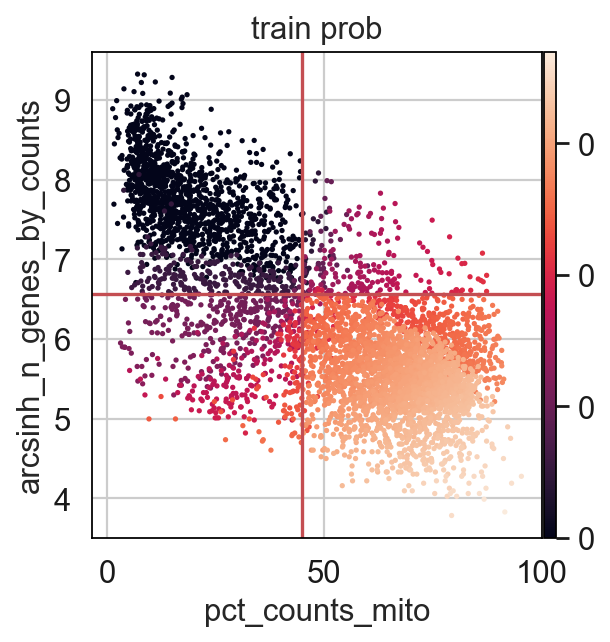

In [33]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='pct_counts_mito', color='train_prob', show=False)
ax.axvline(thresh_mito, color='r')
ax.axhline(thresh_genes, color='r')
plt.show()

---
#### Now, determine probabilities for picking reliable negatives, or "good" cells based on the same thresholds (in the opposite directions)

In [34]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode BELOW our threshold to be ZERO
s1.obs['counts_neg'] = 0

# of all the barcodes ABOVE our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['arcsinh_total_counts']>thresh_counts, 'counts_neg'] = s1.obs.loc[s1.obs['arcsinh_total_counts']>thresh_counts, 'arcsinh_total_counts']
s1.obs['counts_neg'] /= s1.obs['counts_neg'].sum()

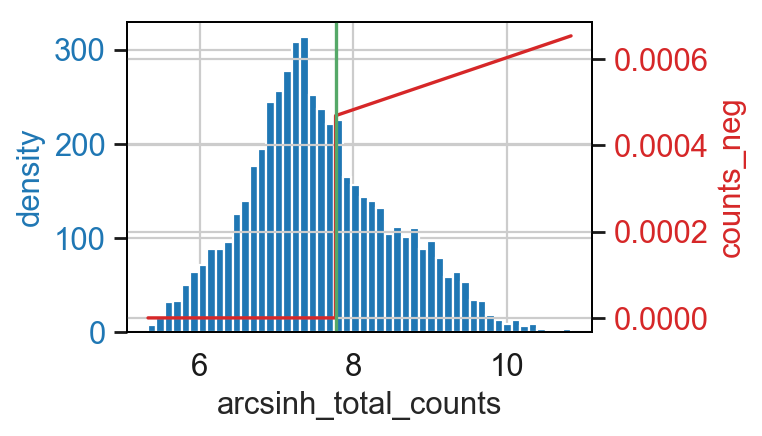

In [35]:
new_order = np.argsort(s1.obs['total_counts'])[::-1]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('arcsinh_total_counts')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['arcsinh_total_counts'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('counts_neg', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['arcsinh_total_counts'], s1.obs['counts_neg'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_counts, color='g') # li threshold

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [36]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['genes_neg'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['arcsinh_n_genes_by_counts']>thresh_genes, 'genes_neg'] = s1.obs.loc[s1.obs['arcsinh_n_genes_by_counts']>thresh_genes, 'arcsinh_n_genes_by_counts']
s1.obs['genes_neg'] /= s1.obs['genes_neg'].sum()

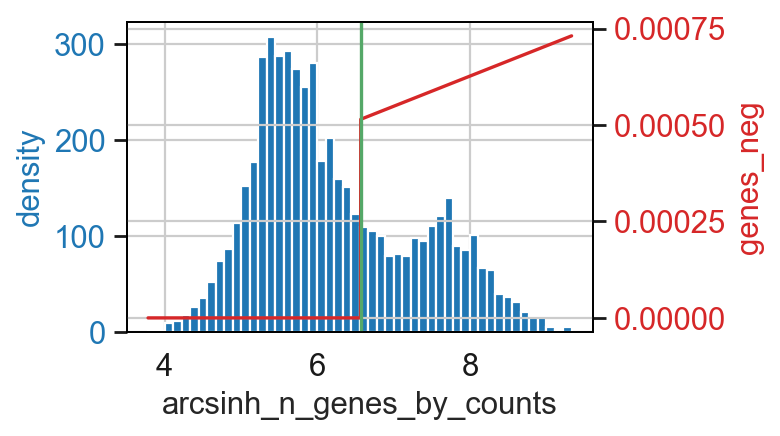

In [37]:
new_order = np.argsort(s1.obs['arcsinh_n_genes_by_counts'])[::-1]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('arcsinh_n_genes_by_counts')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['arcsinh_n_genes_by_counts'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('genes_neg', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['arcsinh_n_genes_by_counts'], s1.obs['genes_neg'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_genes, color='g') # li threshold

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [38]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['mito_neg'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['pct_counts_mito']<thresh_mito, 'mito_neg'] = np.reciprocal(s1.obs.loc[s1.obs['pct_counts_mito']<thresh_mito, 'pct_counts_mito']+1)
s1.obs['mito_neg'] /= s1.obs['mito_neg'].sum()

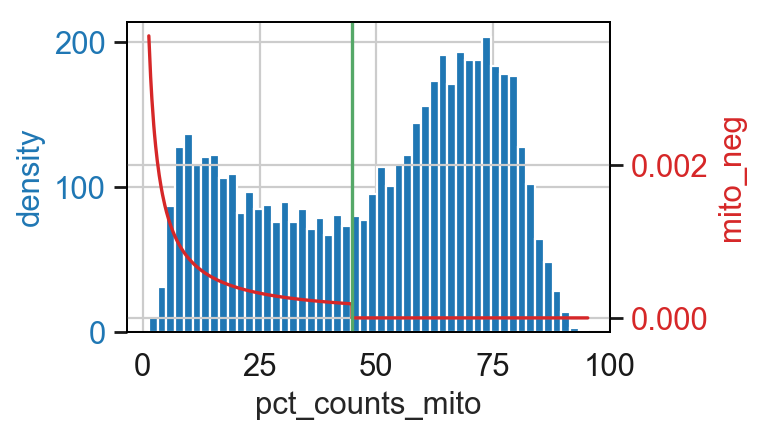

In [39]:
new_order = np.argsort(s1.obs['pct_counts_mito'])[:]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('pct_counts_mito')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['pct_counts_mito'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('mito_neg', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['pct_counts_mito'], s1.obs['mito_neg'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_mito, color='g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [40]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['50_neg'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['pct_counts_in_top_50_genes']<thresh_50, '50_neg'] = np.reciprocal(s1.obs.loc[s1.obs['pct_counts_in_top_50_genes']<thresh_50, 'pct_counts_in_top_50_genes']+1)
s1.obs['50_neg'] /= s1.obs['50_neg'].sum()

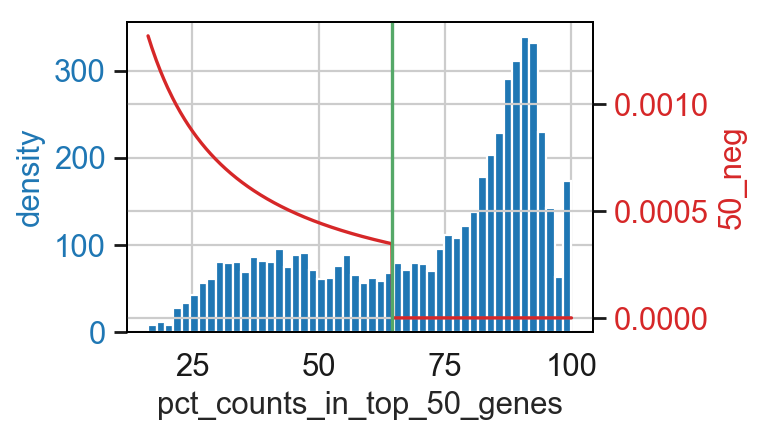

In [41]:
new_order = np.argsort(s1.obs['pct_counts_in_top_50_genes'])[:]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('pct_counts_in_top_50_genes')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['pct_counts_in_top_50_genes'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('50_neg', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['pct_counts_in_top_50_genes'], s1.obs['50_neg'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_50, color='g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [42]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['gficf_neg'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['gf_icf_total']>thresh_gficf, 'gficf_neg'] = s1.obs.loc[s1.obs['gf_icf_total']>thresh_gficf, 'gf_icf_total']
s1.obs['gficf_neg'] /= s1.obs['gficf_neg'].sum()

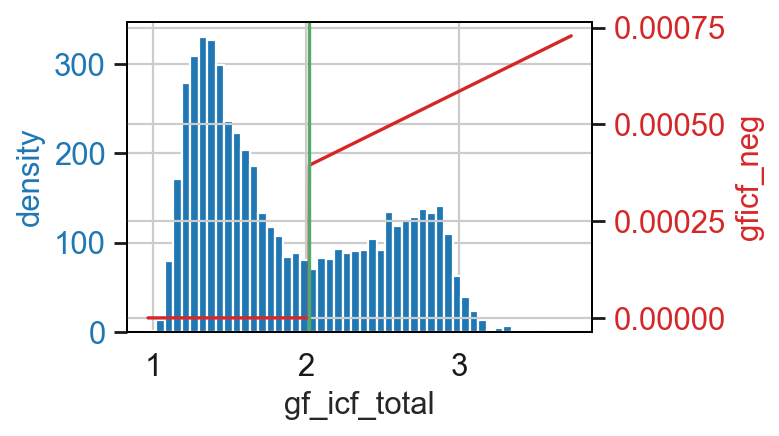

In [43]:
new_order = np.argsort(s1.obs['gf_icf_total'])[::-1]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('gf_icf_total')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['gf_icf_total'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('gficf_neg', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['gf_icf_total'], s1.obs['gficf_neg'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_gficf, color='g') # li threshold

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### combine probabilities for training set (good cells):

In [44]:
# combine and normalize probabilities
s1.obs['neg_prob'] =  s1.obs['genes_neg'] + s1.obs['gficf_neg'] + s1.obs['counts_neg'] + s1.obs['50_neg'] + s1.obs['mito_neg']
s1.obs['neg_prob'] /= s1.obs['neg_prob'].sum()

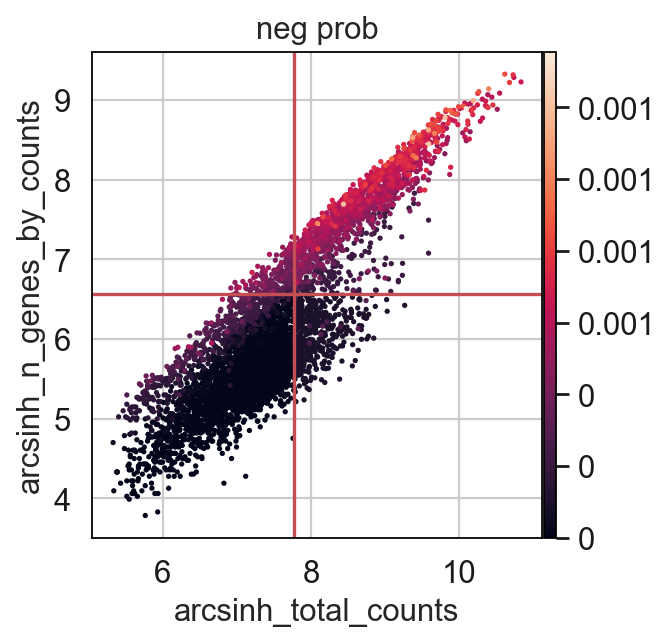

In [45]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='arcsinh_total_counts', color='neg_prob', show=False)
ax.axvline(thresh_counts, color='r')
ax.axhline(thresh_genes, color='r')
plt.show()

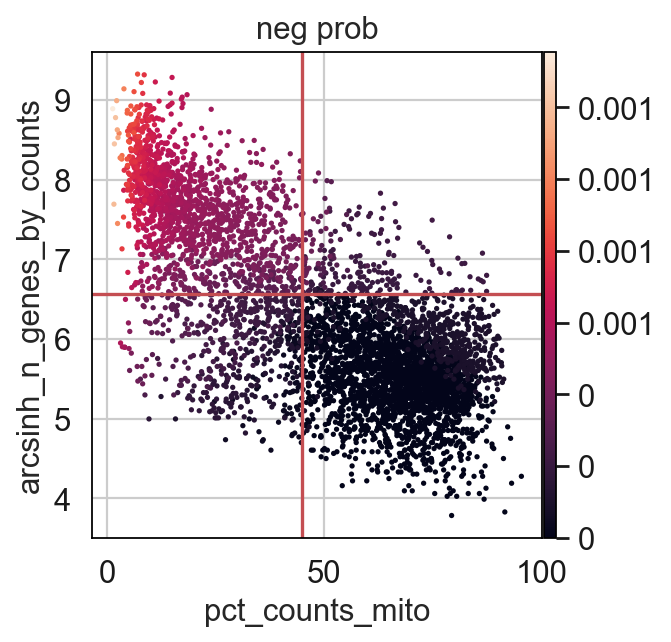

In [46]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='pct_counts_mito', color='neg_prob', show=False)
ax.axvline(thresh_mito, color='r')
ax.axhline(thresh_genes, color='r')
plt.show()

---
#### Randomly sample training set (reliable "positives" or dead/empty cells), and reliable "negative" set or likely good cells

In [47]:
# -1: unlabeled
# 1: positive (dead/empty)
# 0: negative (live)
s1.obs['train'] = -1
s1.obs.iloc[np.random.choice(a=s1.obs.shape[0], size=int(0.25*s1.obs['thresh_filter'].sum()), replace=False, p=s1.obs['neg_prob']),s1.obs.columns.get_loc('train')] = 0
s1.obs.iloc[np.random.choice(a=s1.obs.shape[0], size=int(0.70*(s1.n_obs - s1.obs['thresh_filter'].sum())), replace=False, p=s1.obs['train_prob']),s1.obs.columns.get_loc('train')] = 1

# NOTE: Look at the fractions chosen within "size" parameter. I've noticed that a higher fraction (0.5-0.7) is better for positives (bad cells), 
#       with a lower fraction (0.2-0.4) chosen for negatives (good cells)

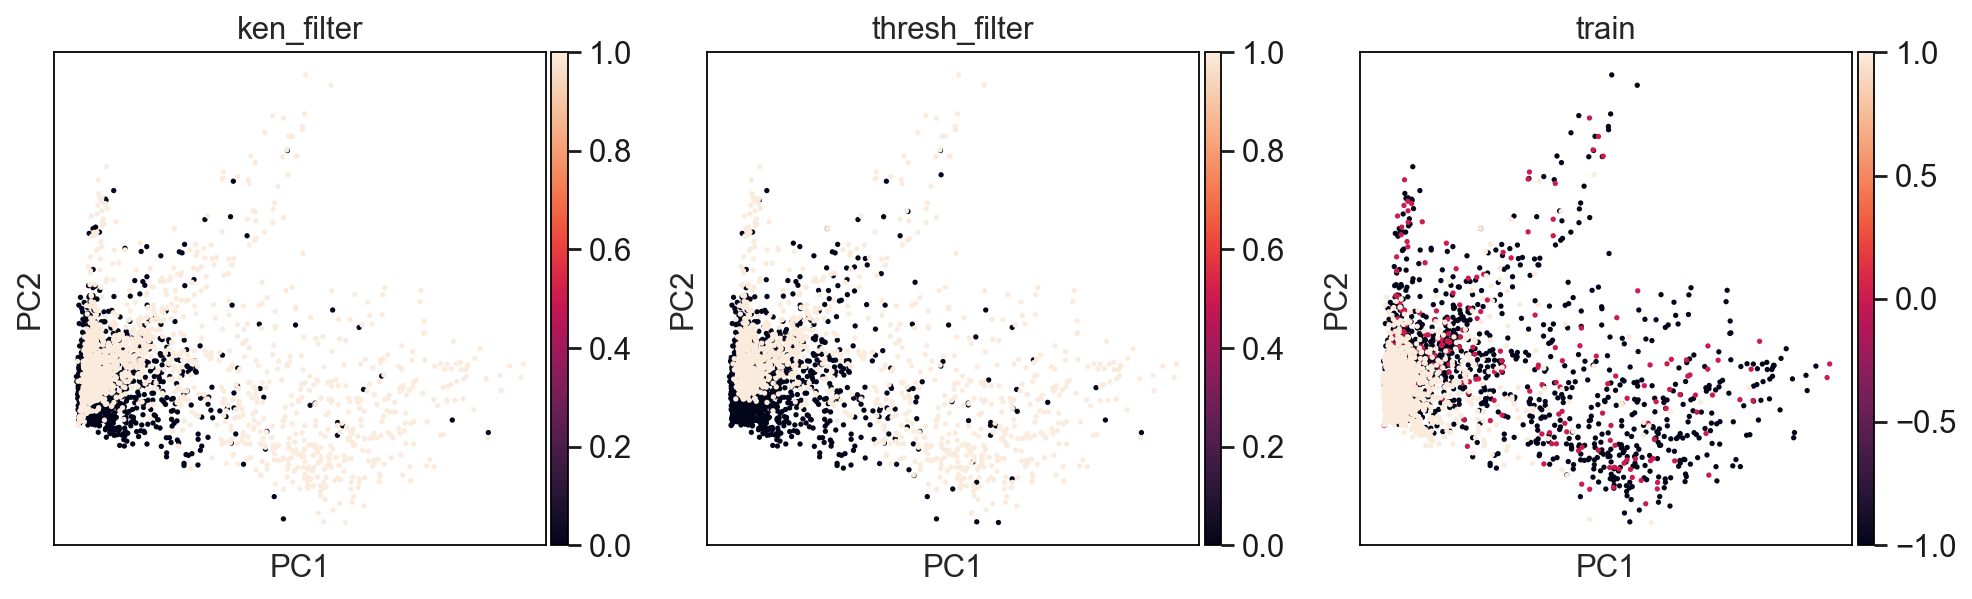

In [48]:
sc.pl.pca(s1, color=['ken_filter','thresh_filter','train'])

Compare our training set to Ken's filter.  
We want a small number here, but <= 50 is acceptable, since our machine learning classifier will work out the kinks...

In [49]:
len(set(s1.obs.loc[s1.obs['train']==1].index).difference(set(s1.obs.loc[s1.obs['ken_filter']==0].index)))

162

In [50]:
len(set(s1.obs.loc[s1.obs['train']==0].index).difference(set(s1.obs.loc[s1.obs['ken_filter']==1].index)))

47

In [51]:
s1.obs['train'].value_counts()

 1    2796
-1    2187
 0     274
Name: train, dtype: int64

---
#### get training set and labels for two-step learning method:

In [52]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['train'].copy(deep=True) # training labels are from .obs df

In [53]:
%%time
rf = RandomForestClassifier(n_estimators=700, n_jobs=-1) # define classifier
s1.obs['twostep_scores'], s1.obs['twostep_labels'] = twoStep(clf=rf, X=X, y=y, thresh='min', n_iter=18)

Step 1 labeled 1139 new positives and 819 new negatives. 229 unlabeled remaining.
Iteration 1: Doing step 2... Step 1 labeled 26 new positives and 124 new negatives. 79 unlabeled remaining.
Iteration 2: Doing step 2... Step 1 labeled 8 new positives and 25 new negatives. 46 unlabeled remaining.
Iteration 3: Doing step 2... Step 1 labeled 3 new positives and 6 new negatives. 37 unlabeled remaining.
Iteration 4: Doing step 2... Step 1 labeled 2 new positives and 2 new negatives. 33 unlabeled remaining.
Iteration 5: Doing step 2... Step 1 labeled 1 new positives and 2 new negatives. 30 unlabeled remaining.
Iteration 6: Doing step 2... Step 1 labeled 1 new positives and 2 new negatives. 27 unlabeled remaining.
Iteration 7: Doing step 2... Step 1 labeled 0 new positives and 4 new negatives. 23 unlabeled remaining.
Iteration 8: Doing step 2... CPU times: user 1min 14s, sys: 3.35 s, total: 1min 18s
Wall time: 13.7 s


#### predict the remaining unlabeled cells using the trained (and re-trained) RandomForestClassifier():

In [54]:
s1.obs['twostep_labels'][y==-1] = rf.predict(X[y==-1]) 
# ignore "setting on copy of slice" warning for now...

/Users/cody/.virtualenvs/qc/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


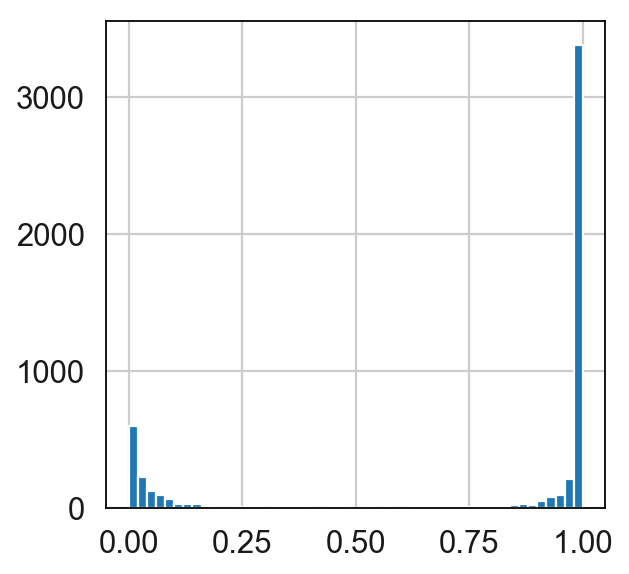

In [55]:
# distribution of scores should be bimodal at 0 and 1
_ = plt.hist(s1.obs['twostep_scores'], bins=50)

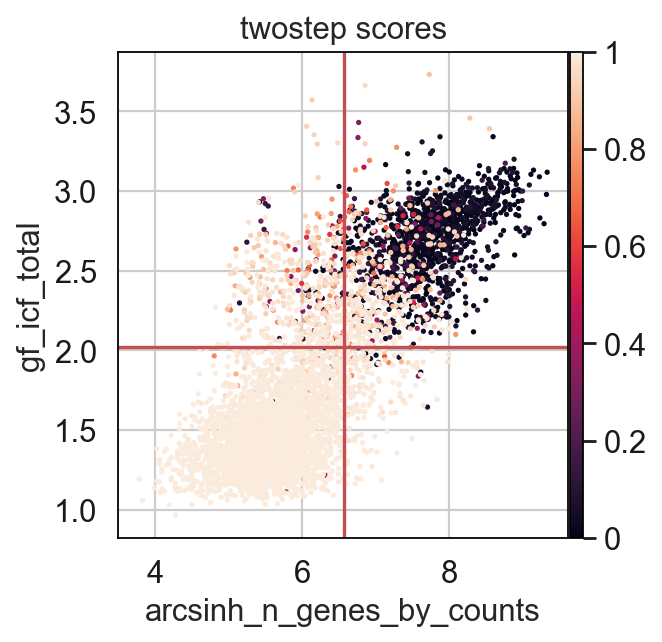

In [56]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='twostep_scores', show=False)
ax.axvline(thresh_genes, color='r')
ax.axhline(thresh_gficf, color='r')
plt.show()

In [57]:
# flip our labels to match Ken's (1: good cell, 0: bad cell)
s1.obs['twostep_labels_flip'] = (~s1.obs['twostep_labels'].astype(bool)).astype(int)

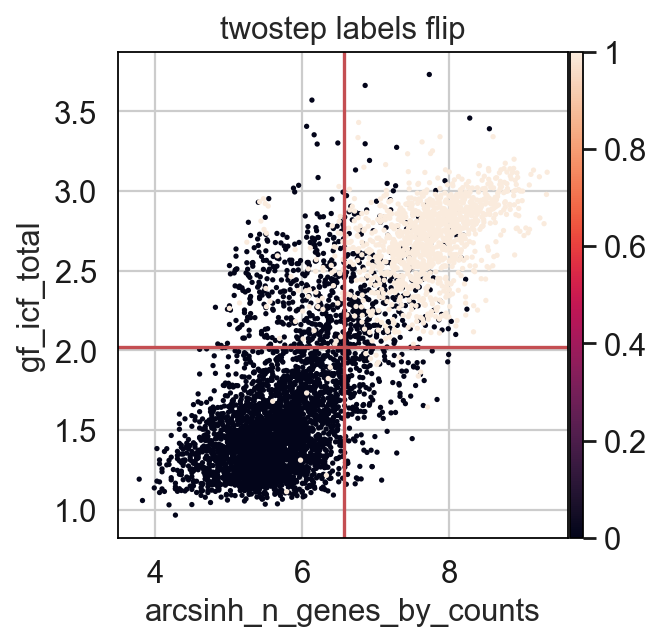

In [58]:
# look at our final labels
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='twostep_labels_flip', show=False)
ax.axvline(thresh_genes, color='r')
ax.axhline(thresh_gficf, color='r')
plt.show()

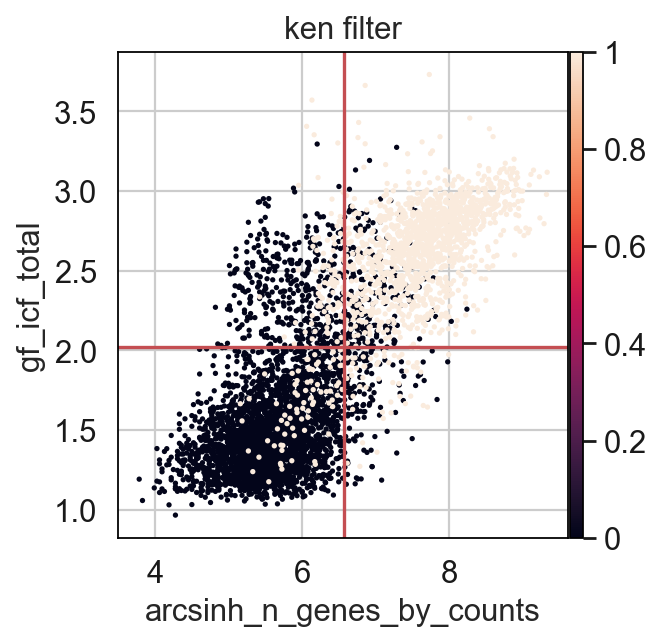

In [59]:
# compare to Ken's labels
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='ken_filter', show=False)
ax.axvline(thresh_genes, color='r')
ax.axhline(thresh_gficf, color='r')
plt.show()

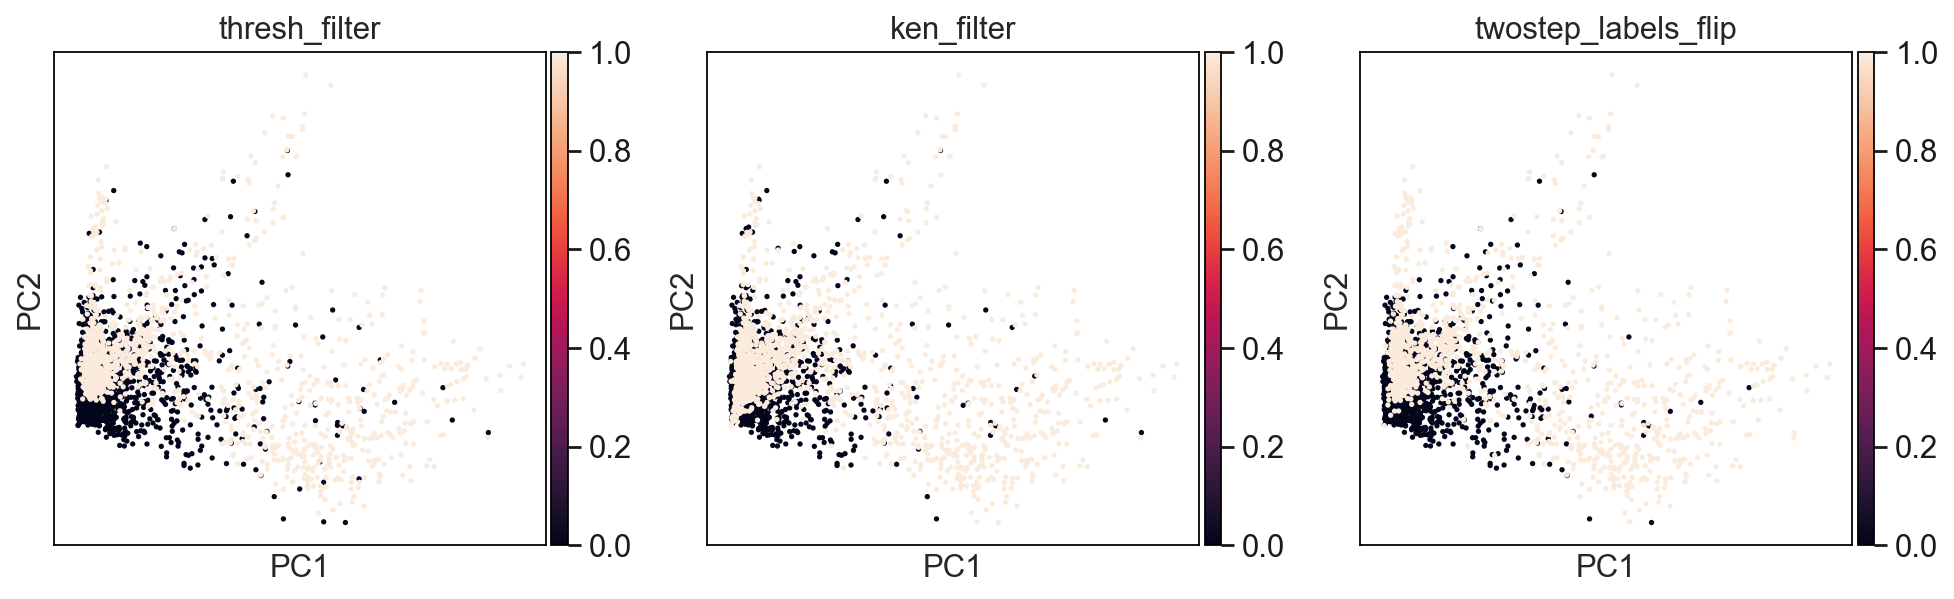

In [60]:
# compare two-step results to threshold filtering and Ken's labels
sc.pl.pca(s1, color=['thresh_filter','ken_filter','twostep_labels_flip'])

In [61]:
len(set(s1.obs_names[s1.obs['twostep_labels_flip']==1]).difference(set(s1.obs_names[s1.obs['ken_filter']==1])))

123

In [62]:
len(set(s1.obs_names[s1.obs['ken_filter']==1]).difference(set(s1.obs_names[s1.obs['twostep_labels_flip']==1])))

387

---
#### Now, reduce dimensions and see how embeddings/cell populations change between the two filterings (Ken and TwoStep)

In [63]:
# generate obs column with ken vs twostep for visualization
s1.obs['compare'] = 'same'
s1.obs.loc[(s1.obs['ken_filter']==1) & (s1.obs['twostep_labels_flip']==0), 'compare'] = 'ken'
s1.obs.loc[(s1.obs['twostep_labels_flip']==1) & (s1.obs['ken_filter']==0), 'compare'] = 'twostep'

In [64]:
# create two new adata objects from ken and twostep filters
s1_ken = s1[s1.obs['ken_filter']==1,:].copy()
s1_twostep = s1[s1.obs['twostep_labels_flip']==1,:].copy()

In [65]:
# preprocess ken's dataset
s1_ken.X = s1_ken.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_ken, min_cells=1)
recipe_fcc(s1_ken, X_final='arcsinh_norm', mito_names='^mt-')
s1_ken.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_ken.obs['n_genes_by_counts'])

... storing 'compare' as categorical


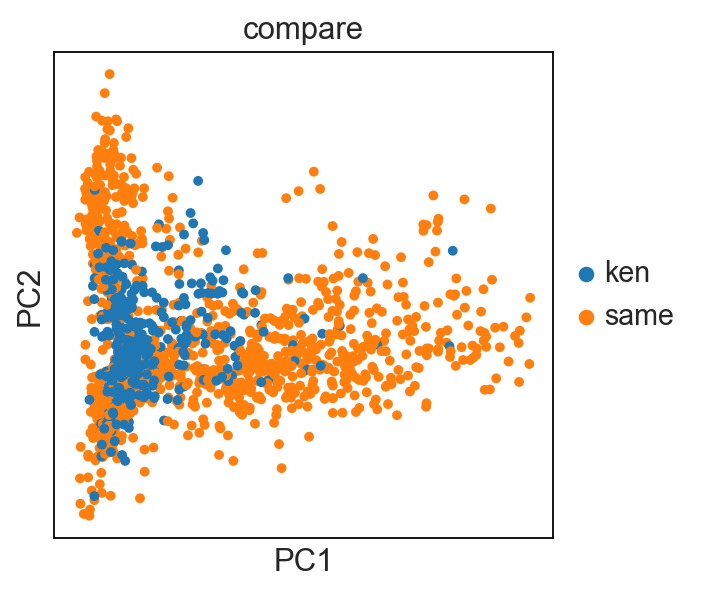

CPU times: user 1.38 s, sys: 381 ms, total: 1.76 s
Wall time: 311 ms


In [66]:
%%time
sc.tl.pca(s1_ken, n_comps=10)
sc.pl.pca(s1_ken, color=['compare'])

In [67]:
sc.pp.neighbors(s1_ken, n_neighbors=int(np.sqrt(s1_ken.n_obs)))
sc.tl.umap(s1_ken)

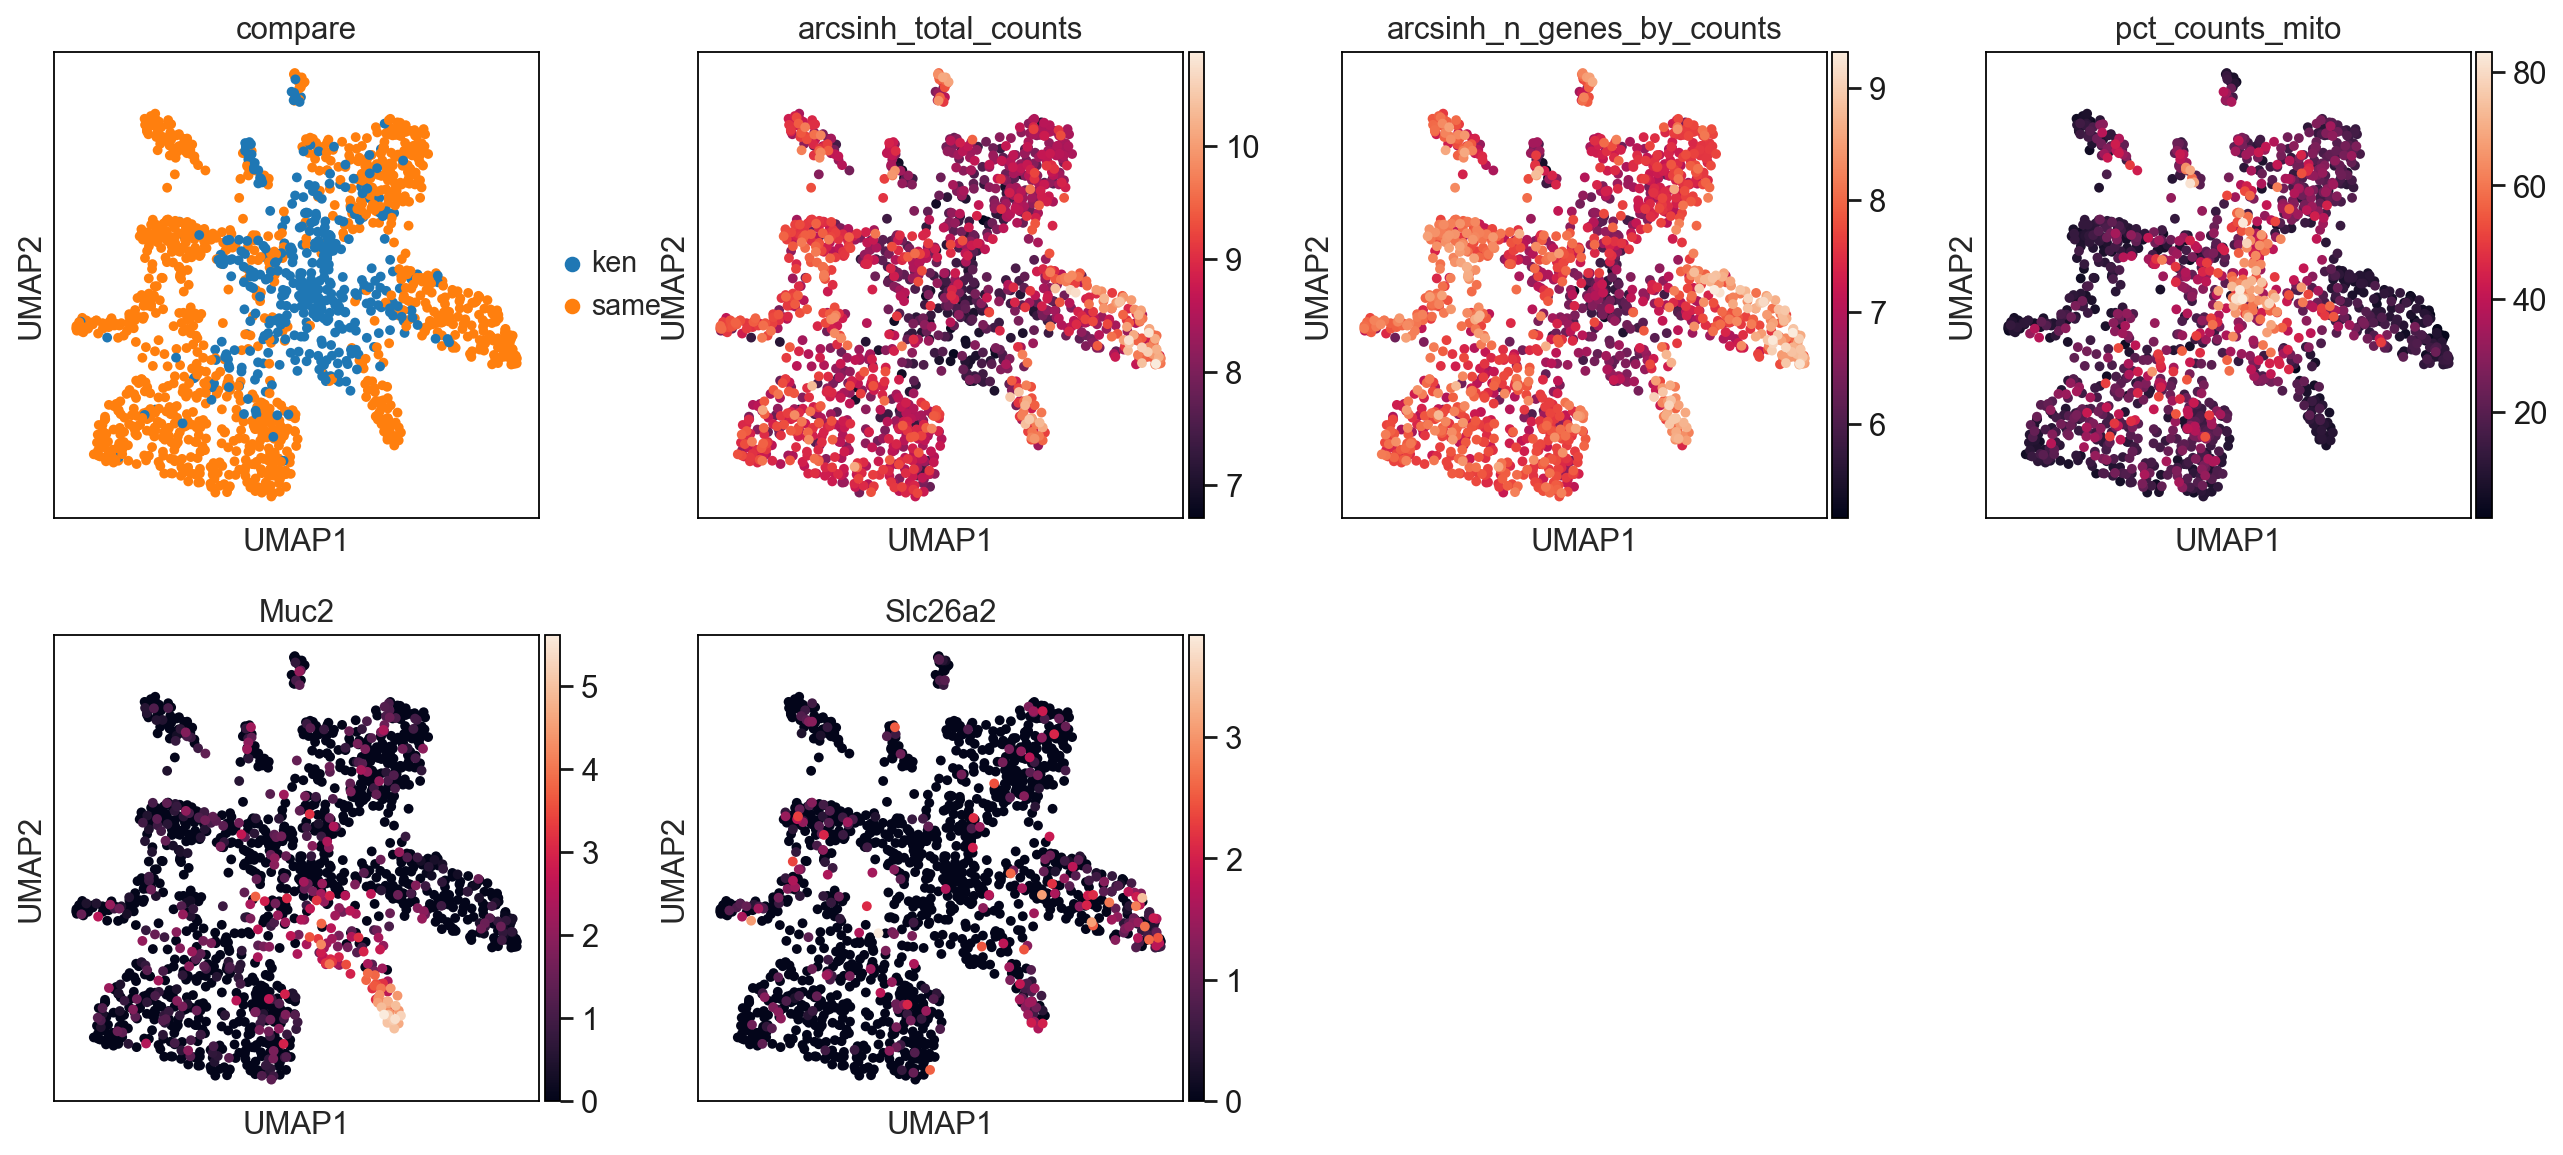

In [68]:
# show UMAP of Ken's data and look at difference from TwoStep
sc.pl.umap(s1_ken, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Slc26a2'])

---
#### Now do the same on TwoStep results

In [69]:
# preprocess
s1_twostep.X = s1_twostep.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_twostep, min_cells=1)
recipe_fcc(s1_twostep, X_final='arcsinh_norm', mito_names='^mt-')
s1_twostep.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_twostep.obs['n_genes_by_counts'])

... storing 'compare' as categorical


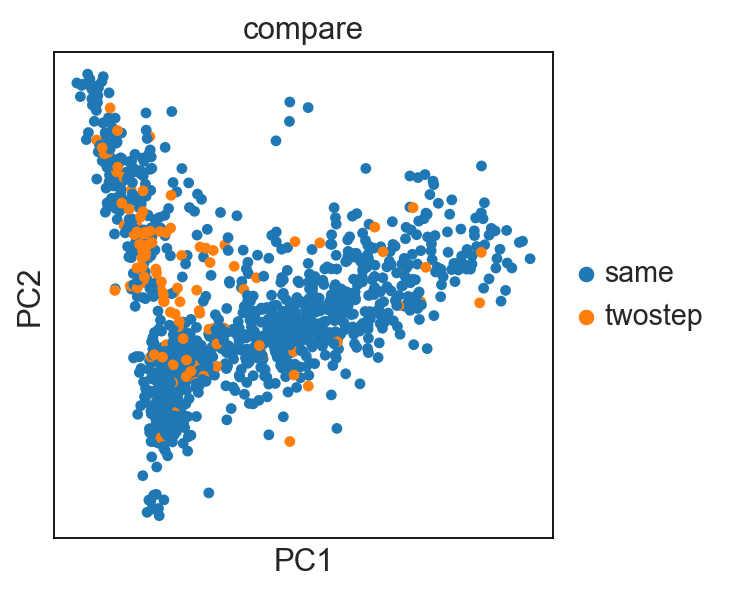

CPU times: user 1.36 s, sys: 294 ms, total: 1.65 s
Wall time: 271 ms


In [70]:
%%time
sc.tl.pca(s1_twostep, n_comps=10)
sc.pl.pca(s1_twostep, color=['compare'])

In [71]:
sc.pp.neighbors(s1_twostep, n_neighbors=int(np.sqrt(s1_twostep.n_obs)))
sc.tl.umap(s1_twostep)

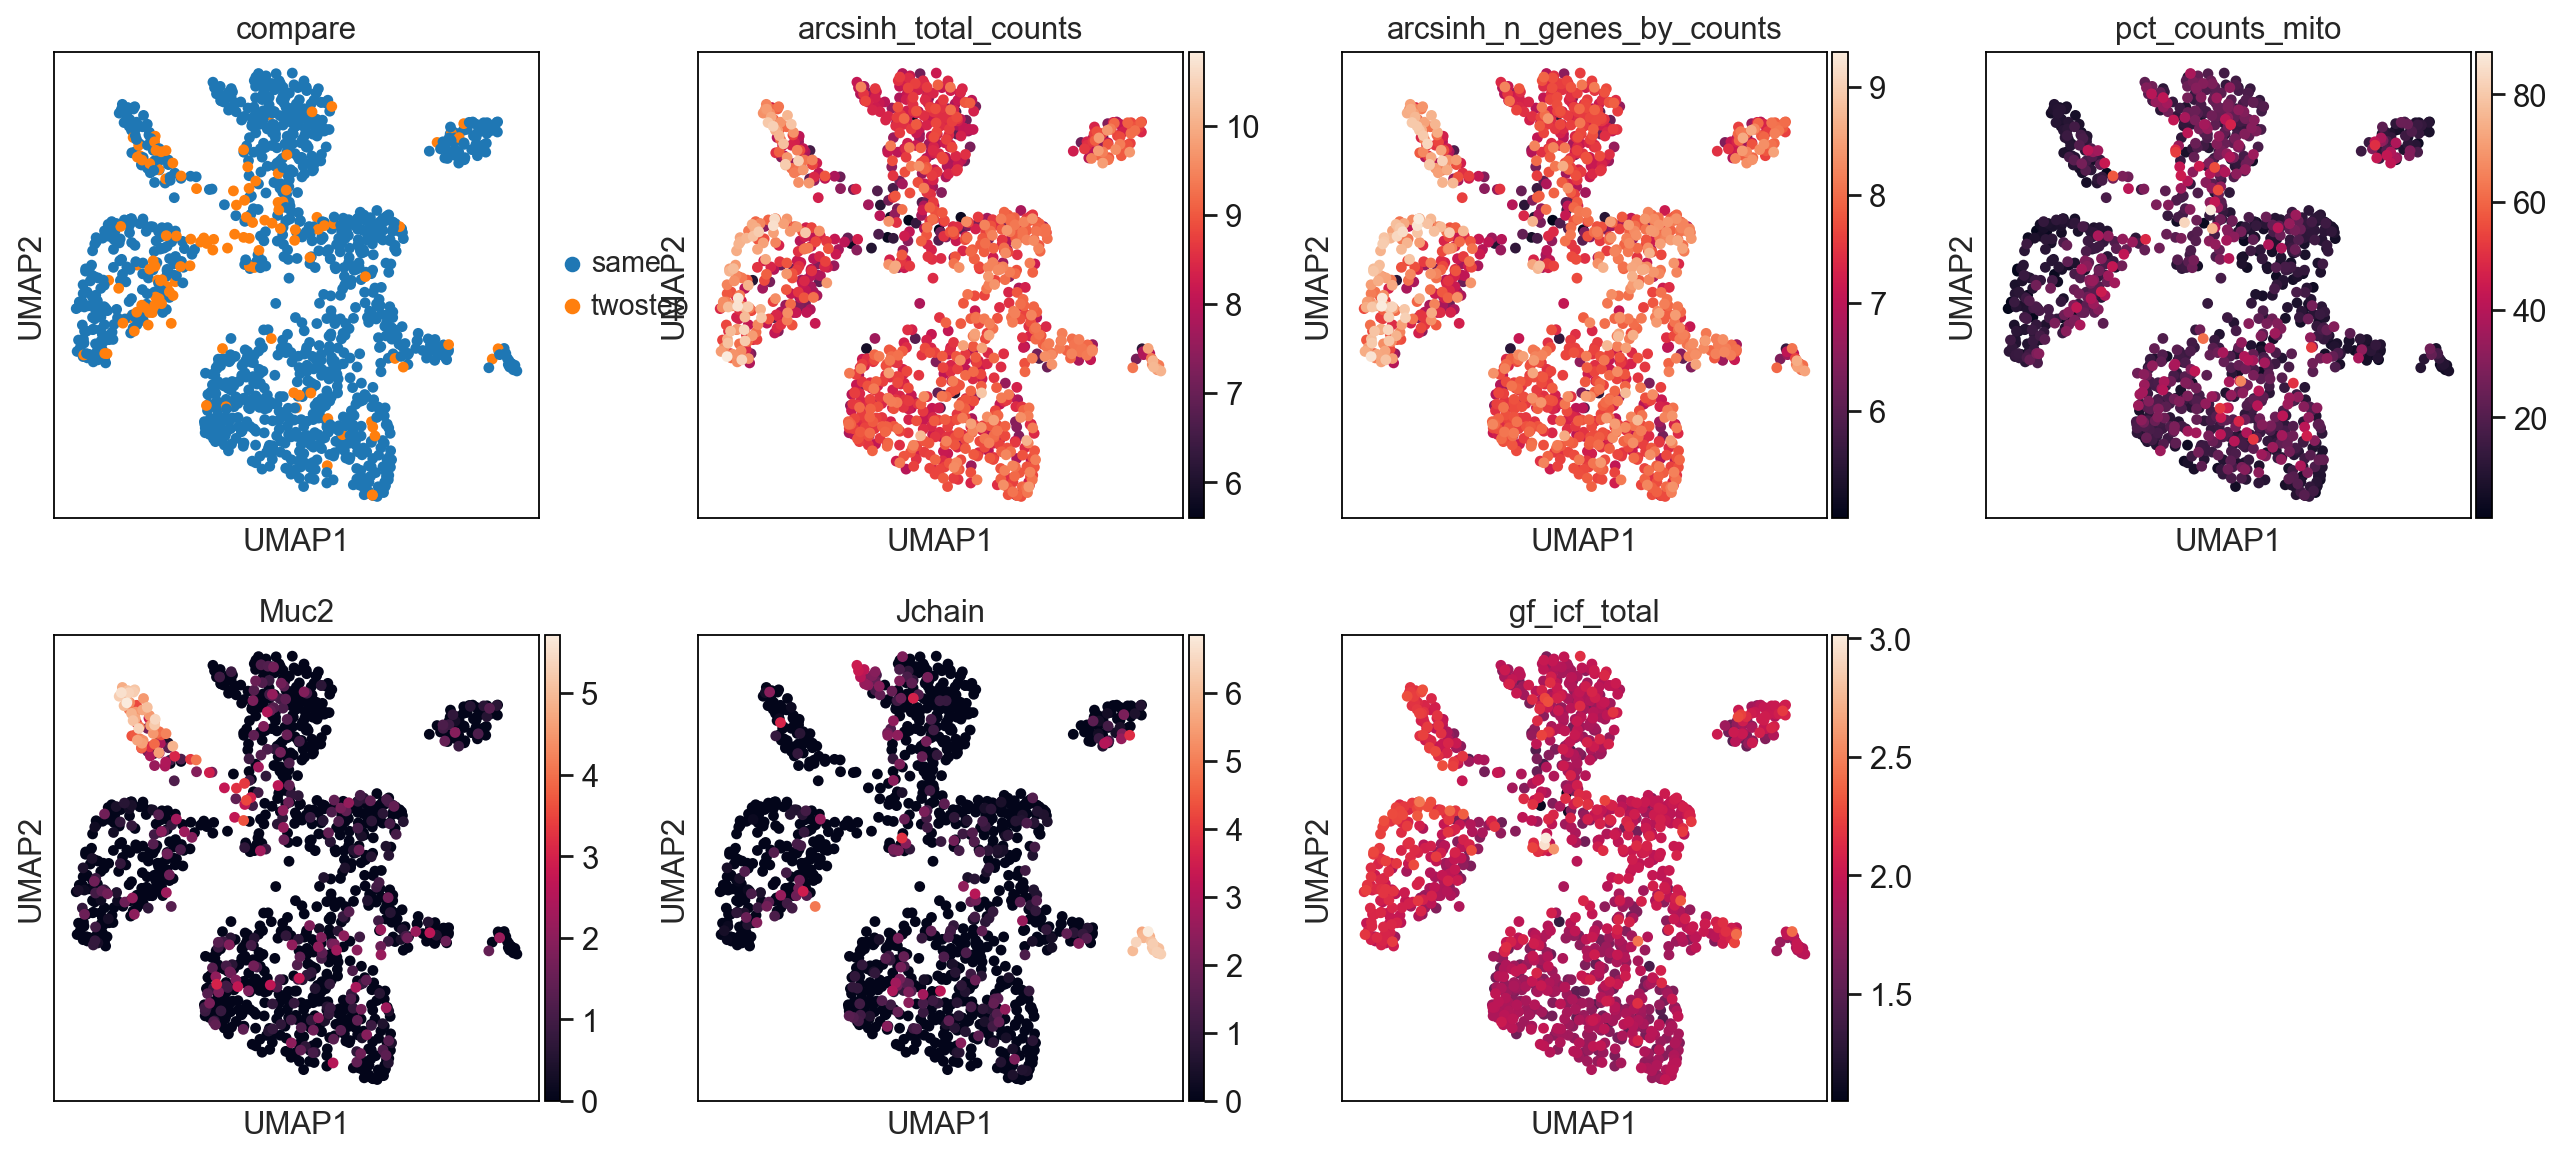

In [72]:
sc.pl.umap(s1_twostep, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Jchain','gf_icf_total'])